Install tensorflow hub for pre-trained models

In [20]:
!pip install tensorflow_hub  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Installing tensorflow dataset

In [21]:
!pip install tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Pre-requisists

In [22]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

Load IMPD Movie Reviews dataset

In [23]:
from os.path import split
train_data, test_data = tfds.load(name="imdb_reviews", 
                                  split=["train", "test"], 
                                  batch_size=-1, 
                                  as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)


In [24]:
train_examples.shape, train_labels.shape

((25000,), (25000,))

### Load a pretrained embedding model called gnews-swivel-20dim. 

(Google trained this network on GNEWS data and can convert raw text into vectors.)

In [25]:
model = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(model, 
                           output_shape=[20], 
                           input_shape=[], 
                           dtype=tf.string, 
                           trainable=True)

In [26]:
# Check wort-to-vector conversion
print(hub_layer(train_examples[:2]))

tf.Tensor(
[[ 1.7657859  -3.882232    3.913424   -1.5557289  -3.3362343  -1.7357956
  -1.9954445   1.298955    5.081597   -1.1041285  -2.0503852  -0.7267516
  -0.6567596   0.24436145 -3.7208388   2.0954835   2.2969332  -2.0689783
  -2.9489715  -1.1315986 ]
 [ 1.8804485  -2.5852385   3.4066994   1.0982676  -4.056685   -4.891284
  -2.7855542   1.3874227   3.8476458  -0.9256539  -1.896706    1.2113281
   0.11474716  0.76209456 -4.8791065   2.906149    4.7087674  -2.3652055
  -3.5015903  -1.6390051 ]], shape=(2, 20), dtype=float32)


Add an output layer for binary classification

In [27]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 20)                400020    
                                                                 
 dense_2 (Dense)             (None, 16)                336       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Save initial random weights for later reference
init_weights = model.get_weights()

Split train set and validation set

In [29]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

### Train the model

In [30]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 52ms/step - loss: 1.0986 - accuracy: 0.5252 - val_loss: 0.8095 - val_accuracy: 0.5196
Epoch 2/40
30/30 [==============================] - 1s 40ms/step - loss: 0.7413 - accuracy: 0.5799 - val_loss: 0.6946 - val_accuracy: 0.6017
Epoch 3/40
30/30 [==============================] - 1s 46ms/step - loss: 0.6455 - accuracy: 0.6505 - val_loss: 0.6156 - val_accuracy: 0.6710
Epoch 4/40
30/30 [==============================] - 1s 40ms/step - loss: 0.5862 - accuracy: 0.6982 - val_loss: 0.5765 - val_accuracy: 0.7032
Epoch 5/40
30/30 [==============================] - 1s 39ms/step - loss: 0.5477 - accuracy: 0.7322 - val_loss: 0.5473 - val_accuracy: 0.7290
Epoch 6/40
30/30 [==============================] - 1s 40ms/step - loss: 0.5149 - accuracy: 0.7577 - val_loss: 0.5205 - val_accuracy: 0.7484
Epoch 7/40
30/30 [==============================] - 1s 47ms/step - loss: 0.4834 - accuracy: 0.7791 - val_loss: 0.4947 - val_accuracy: 0.7679
Epoch 8/40
30

Evaluate the model

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

def summarize_loss(history):
  history_dict = history.history
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

def summarize_accuracy(history):
  history_dict = history.history
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

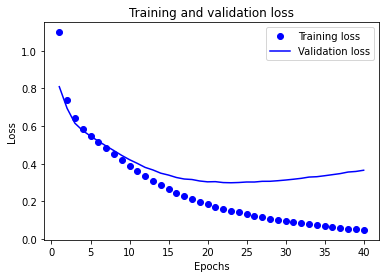

In [32]:
summarize_loss(history)



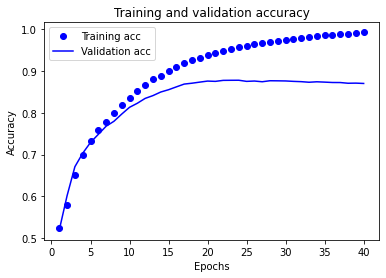

In [33]:
summarize_accuracy(history)

It seems this model has started overfitting arround 30 epochs. Best validation accuracy is arround 85-88%.

Use of Early stopping

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

model.set_weights(init_weights)

history2 = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    callbacks=[monitor],
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 1s 41ms/step - loss: 0.9542 - accuracy: 0.5389 - val_loss: 0.7034 - val_accuracy: 0.6056
Epoch 2/40
30/30 [==============================] - 1s 40ms/step - loss: 0.6485 - accuracy: 0.6385 - val_loss: 0.6203 - val_accuracy: 0.6645
Epoch 3/40
30/30 [==============================] - 1s 40ms/step - loss: 0.5952 - accuracy: 0.6891 - val_loss: 0.5855 - val_accuracy: 0.6948
Epoch 4/40
30/30 [==============================] - 1s 41ms/step - loss: 0.5602 - accuracy: 0.7242 - val_loss: 0.5574 - val_accuracy: 0.7220
Epoch 5/40
30/30 [==============================] - 1s 40ms/step - loss: 0.5293 - accuracy: 0.7491 - val_loss: 0.5309 - val_accuracy: 0.7463
Epoch 6/40
30/30 [==============================] - 1s 39ms/step - loss: 0.4979 - accuracy: 0.7705 - val_loss: 0.5040 - val_accuracy: 0.7605
Epoch 7/40
30/30 [==============================] - 1s 40ms/step - loss: 0.4654 - accuracy: 0.7914 - val_loss: 0.4773 - val_accuracy: 0.7748
Epoch 8/40
30

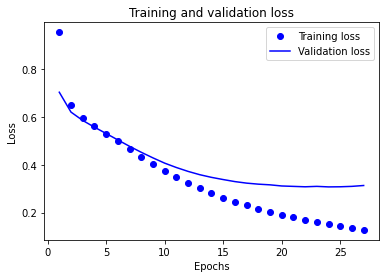

In [35]:
summarize_loss(history2)

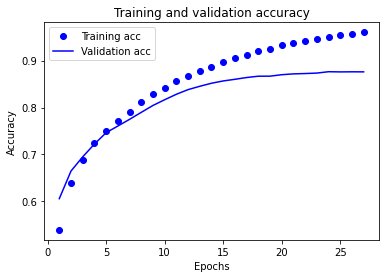

In [36]:
summarize_accuracy(history2)